In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

In [2]:
with open('Korean_movie_reviews_2016_small.txt', encoding='utf-8') as f:
    docs = [doc.strip().split('\t') for doc in f ]
    docs = [(doc[0], int(doc[1])) for doc in docs if len(doc) == 2]
    texts, labels = zip(*docs)

In [3]:
len(texts)

29875

In [4]:
from transformers import BertTokenizer, TFAlbertForSequenceClassification

In [5]:
tokenizer= BertTokenizer.from_pretrained("kykim/albert-kor-base")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [6]:
from tensorflow.keras.utils import to_categorical
y_one_hot = to_categorical(labels)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(texts, y_one_hot, test_size=0.2, random_state=0)

In [8]:
len(X_train)

23900

In [9]:
X_train_tokenized = tokenizer(X_train, return_tensors="np", max_length=30, padding='max_length', truncation=True)
X_test_tokenized = tokenizer(X_test, return_tensors="np", max_length=30, padding='max_length', truncation=True)

In [10]:
model = TFAlbertForSequenceClassification.from_pretrained("kykim/albert-kor-base", num_labels=2, from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertForSequenceClassification: ['albert.embeddings.position_ids', 'sop_classifier.classifier.bias', 'sop_classifier.classifier.weight']
- This IS expected if you are initializing TFAlbertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [11]:
optimizer = tf.keras.optimizers.Adam(2e-5)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
checkpoint_filepath = "./checkpoints/checkpoint_albert_kr"
mc = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', mode='min', 
                     save_best_only=True, save_weights_only=True)

In [13]:
history = model.fit(dict(X_train_tokenized), y_train, epochs=10, batch_size=128, 
                    validation_split=0.1, callbacks=[es, mc])

Epoch 1/10
169/169 [==============================] - 1419s 8s/step - loss: 0.3981 - accuracy: 0.8244 - val_loss: 0.3181 - val_accuracy: 0.8632
Epoch 2/10
169/169 [==============================] - 1405s 8s/step - loss: 0.2553 - accuracy: 0.8983 - val_loss: 0.2926 - val_accuracy: 0.8795
Epoch 3/10
169/169 [==============================] - 1404s 8s/step - loss: 0.1951 - accuracy: 0.9276 - val_loss: 0.3022 - val_accuracy: 0.8816
Epoch 4/10
169/169 [==============================] - 1408s 8s/step - loss: 0.1378 - accuracy: 0.9519 - val_loss: 0.3584 - val_accuracy: 0.8803
Epoch 5/10
169/169 [==============================] - 1404s 8s/step - loss: 0.1053 - accuracy: 0.9642 - val_loss: 0.3650 - val_accuracy: 0.8782
Epoch 5: early stopping


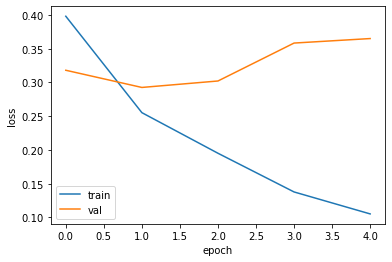

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

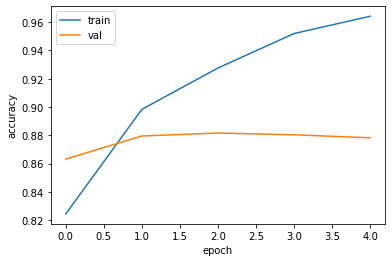

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'])
plt.show()

In [16]:
model.load_weights(checkpoint_filepath)
model.evaluate(dict(X_test_tokenized), np.array(y_test))

187/187 [==============================] - 140s 750ms/step - loss: 0.2701 - accuracy: 0.8897


[0.2700795829296112, 0.889707088470459]

In [17]:
y_preds = model.predict(dict(X_test_tokenized))
prediction_probs = tf.nn.softmax(y_preds.logits,axis=1).numpy()
y_predictions = np.argmax(prediction_probs, axis=1)
y_test = np.argmax(y_test, axis=1)
from sklearn.metrics import classification_report
print(classification_report(y_predictions, y_test))

187/187 [==============================] - 143s 752ms/step
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      2820
           1       0.90      0.89      0.89      3155

    accuracy                           0.89      5975
   macro avg       0.89      0.89      0.89      5975
weighted avg       0.89      0.89      0.89      5975

